## Menu Item Recommendation Exercise

### [1] Import necessary modules

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geohash
from sklearn.manifold import TSNE
import sklearn
import seaborn as sns
import lang_processor
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

### [2] Define datapaths and load the dataset

In [2]:
# Define datapaths
module_path = os.path.abspath('')
data_path = os.path.join(module_path, 'data')
file_path = os.path.join(data_path, 'products.gz')
dataset = pd.read_parquet(file_path, engine='pyarrow')
dataset = dataset.dropna()

### [3] Some statistics on the Dataset

In [3]:
# unique products
print("Number of distinct Vendors: {}".format(dataset.vendor_id.nunique()))
print("Number of distinct Products: {}".format(dataset.product_id.nunique()))
print("Number of distinct Geohash: {}".format(dataset.vendor_geohash.nunique()))

Number of distinct Vendors: 6464
Number of distinct Products: 116524
Number of distinct Geohash: 1834


### [4] Visualize the distribution of vendors across the city
* We need this to analyise the clusters of vendors.
* Specifically, we do NOT recommend a menu item by comparing two vendors which are far apart from each other
* Above is under the assumption that the delivery app would only recommend vendors that are within a 'defined' reachable distance from the customers

#### We could use the distribution below to target new vendors in the region not explored previously. This could increase the customer base since customers would usually prefer to order food from a restaurant in their neighbourhood.

In [4]:
def map_geohash(item: tuple) -> list:
    '''
    Convert tuple of string cordinates to a list of float
    '''
    cordinates = geohash.decode(item)
    return [float(item) for item in cordinates]

In [5]:
def geo_distribution(geo_data: list, count=None) -> None:
    """Distribution of geohash in the city"""
    geo_data = [map_geohash(item) for item in geo_data]
    geo_data = np.asarray(geo_data)
    palette = sns.color_palette("bright", 10)
    if(count is not None):
        count = np.asarray(count)
    sns.scatterplot(geo_data[:,0], geo_data[:,1], size=count, palette=palette)

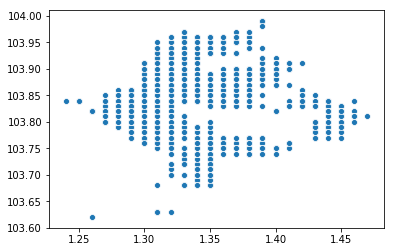

In [6]:
geo_data = dataset.vendor_geohash.unique().tolist() # get (x,y) cordiants for each geohash
geo_distribution(geo_data)

### [5] Visualize the distribution of orders in different geo locations

#### Following observations from the plot can help design a targetted recommendation system

* Some clusters in the region with high order density (hotspots)
* Comparing the distribution of orders with the distribution of vendors, we note that some vendors have very low order count in their neighobourhood (for example the two big clusters at right and bottom of the figure)
* We can pay more emphasis on vendors who have low order count

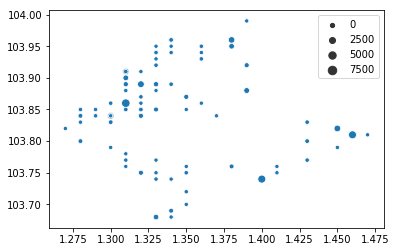

In [13]:
subset = dataset[['vendor_geohash', 'order_count']][:]
subset['total_count'] = subset[['order_count']].groupby(subset['vendor_geohash']).transform('sum')
subset = subset[['vendor_geohash', 'total_count']][:]
subset = subset.drop_duplicates()
subset = subset.sample(n=100)
geo_data = subset['vendor_geohash'].tolist()
count = subset['total_count'].tolist()
geo_distribution(geo_data, count)

### [6] Based on Above, we provide a recommendation as follows:

* Cluster the vendors together that have similar service and those in the same or adjacent neighbourhoods
* Each cluster now represents a homogeneous set or vendors
* For each cluster, we observed the statistics of different menu items and make a recommendation as follows:
    * For two vendors A and B serving Fried Noodles, we recommend the vendor with lower than average order count to  consider improvements in terms of discount and or variation in the recipe.
    * The variation could be suggested by pooling the description of similar and frequently sold items in the cluster
    * The disount factor and other offers can be suggested by pooling the price of similar item in the neighbourhood.

### [7] Data Clean-Up 
* Process product name using language transformation defined in the `lang_processor.py` script
* Encode categorical product name using the TF-IDF transformation
* TF-IDF will result in a high-dimensional vector and the computational cost of K-means would be high. We apply a compressive transformation to the TF-IDF vectors using the SVD. SVD has advantage over PCA in the sense that PCA operates on the Covariance matrix which in itself is expensive to compute. Moreover, SVD is effectice on sparse dataset which is indeed our case

In [14]:
dataset['product_name'] = dataset['product_name'].apply(lambda x: lang_processor.pre_process(x))

In [15]:
# instantiate labelencoder object
le = LabelEncoder()
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
product_feat = vectorizer.fit_transform(dataset['product_name'])
print("Shape of TF-IDF features from product name: {}".format(product_feat.shape))

Shape of TF-IDF features from product name: (116524, 9565)


In [17]:
# learnable-parameters. Out of the scope of current-work. Can be tuned in the future
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
product_feat = svd.fit_transform(product_feat)
print("Shape of transformed features from product name: {}".format(product_feat.shape))

Shape of transformed features from product name: (116524, 10)


In [20]:
# Combine the product and geo dataset as a final preparation for clustering
geo_feat = dataset.vendor_geohash.tolist() # get (x,y) cordiants for each geohash
geo_feat = [map_geohash(item) for item in geo_feat]
geo_feat = np.asarray(geo_feat)
print("Shape of transformed features from vendor geohash: {}".format(geo_feat.shape))

Shape of transformed features from vendor geohash: (116524, 2)


### [8] Cluster the data into multiple buckets
 * Suggest recommendations to vendors from each bucket.
 * Use the data within the bucket to make a recommendation

In [28]:
# optimal value of `n_clusters` currently out of scope of the present work. To be determined in future
data = np.column_stack((geo_feat,product_feat))
# del geo_feat
# del product_feat

km = KMeans(n_clusters=50)
km.fit(data)
labels = km.labels_
dataset['labels'] = labels

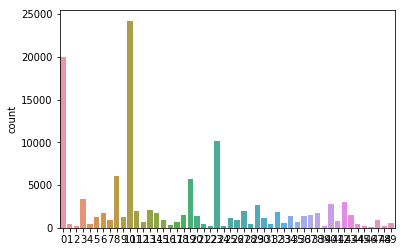

In [29]:
# Distribution of records in different clusters.
sns.countplot(labels)

### [9] Analysis on distribution of product orders in different clusters
* Based on the distribution of clusters above, lets observe one big and one small cluster

number of points in cluster-0 is 20000
number of points in cluster-3 is 3317


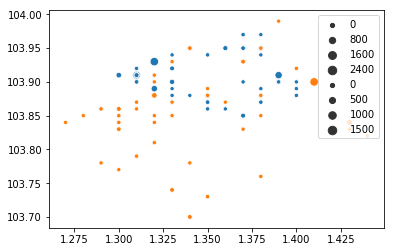

In [30]:
def analyise_cluster_distribution(cluster_id=1):
    subset = dataset[['vendor_geohash', 'order_count', 'labels']][:]
    subset = subset[subset['labels']==cluster_id]
    print("number of points in cluster-{} is {}".format(cluster_id, len(subset)))
    subset['total_count'] = subset[['order_count']].groupby(subset['vendor_geohash']).transform('sum')
    subset = subset[['vendor_geohash', 'total_count', 'labels']][:]
    subset = subset.drop_duplicates()
    subset = subset.sample(n=50)
    geo_data = subset['vendor_geohash'].tolist()
    count = subset['total_count'].tolist()
    geo_distribution(geo_data, count)

analyise_cluster_distribution(cluster_id=0)
analyise_cluster_distribution(cluster_id=3)

### [10] Example-1: Product Recommendation in each cluster / peer-group
* Let's take cluster-2 as an example:

* #### We observe that this cluster mostly contains vendors serving beverages. 
* #### We also observe that two vendors (#272 and #696) dominate the beverage market


In [89]:
subset = dataset[:]
subset = subset[subset['labels']==2][:]
subset = subset.sort_values(by='order_count', ascending=False)
print("Number of distinct Vendors: {}".format(subset.vendor_id.nunique()))
print("Number of distinct Products: {}".format(subset.product_id.nunique()))
print("Number of distinct Geohash: {}".format(subset.vendor_geohash.nunique()))

Number of distinct Vendors: 70
Number of distinct Products: 259
Number of distinct Geohash: 67


In [90]:
subset.head(50)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,labels
12248,12248,696,w23b4u4,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,31,2
6000,6000,272,w21xxgg,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,22,2
289121,289121,831,w21zkpm,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,16,2
284141,284141,889,w21zu1v,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,14,2
283821,283821,1185,w23b1tr,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,14,2
279376,279376,130,w21zc5n,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,13,2
277931,277931,272,w21xxgg,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,12,2
276560,276560,2519,w21zgf7,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,12,2
275742,275742,1185,w23b1tr,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,12,2
275297,275297,1698,w21z8dx,green tea cream frappuccino,A refreshing blend of sweetened matcha green t...,12,2


Total vendors [blue]: 67
Top-k vendors [orange]: 3


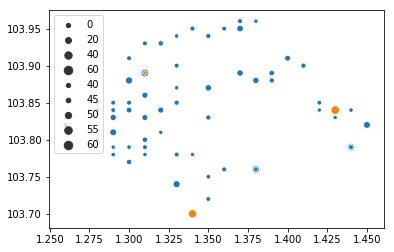

In [93]:
subset1 = subset.copy()
subset1['total_count'] = subset1[['order_count']].groupby(subset1['vendor_geohash']).transform('sum')
subset1 = subset1[['vendor_geohash', 'total_count']][:]
subset1 = subset1.drop_duplicates()
print("Total vendors [blue]: {}".format(len(subset1)))
geo_data = subset1['vendor_geohash'].tolist()
count = subset1['total_count'].tolist()
geo_distribution(geo_data, count)

subset1 = subset.copy()
subset1 = subset1[subset1['vendor_id'].isin(['272', '696', '831'])][:]
subset1['total_count'] = subset1[['order_count']].groupby(subset1['vendor_geohash']).transform('sum')
subset1 = subset1[['vendor_geohash', 'total_count']][:]
subset1 = subset1.drop_duplicates()
print("Top-k vendors [orange]: {}".format(len(subset1)))
geo_data = subset1['vendor_geohash'].tolist()
count = subset1['total_count'].tolist()
geo_distribution(geo_data, count)
del subset1

### Recommending "Green Tea Cream Frappuccino" to vendors serving beverages
* Not enough market coverage in the west and the north of the city
* Vendors in this region recommended to incorporate this product

### [11] Example-1: Product Recommendation in each cluster / peer-group
* Let's take cluster-15 as an example:

* #### We observe that this cluster mostly contains vendors serving Chicken Sub or Chicken Ham. 
* #### A few vendors dominate the market in this peer-group. For example, vendors: #1057, #1269, #390, and #1295




In [104]:
subset = dataset[:]
subset = subset[subset['labels']==15][:]
subset = subset.sort_values(by='order_count', ascending=False)
print("Number of distinct Vendors: {}".format(subset.vendor_id.nunique()))
print("Number of distinct Products: {}".format(subset.product_id.nunique()))
print("Number of distinct Geohash: {}".format(subset.vendor_geohash.nunique()))

Number of distinct Vendors: 83
Number of distinct Products: 887
Number of distinct Geohash: 83


In [95]:
subset.head(50)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,labels
26200,26200,1057,w23b1tq,chicken teriyaki sub,"An Asian classic, is made with tender chicken ...",96,15
13381,13381,1269,w21zvbb,chicken teriyaki sub,"An Asian classic, is made with tender chicken ...",87,15
24084,24084,390,w21zkyf,roasted chicken sub,Feel peckish for chicken? Then try our Oven Ro...,84,15
11253,11253,1295,w23b4wd,roasted chicken sub,Feel peckish for chicken? Then try our Oven Ro...,73,15
22341,22341,1269,w21zvbb,roasted chicken sub,Feel peckish for chicken? Then try our Oven Ro...,72,15
16780,16780,1295,w23b4wd,chicken teriyaki sub,"An Asian classic, is made with tender chicken ...",68,15
18064,18064,96,w21zs61,roasted chicken sub,Feel peckish for chicken? Then try our Oven Ro...,66,15
2755,2755,1057,w23b1tq,roasted chicken sub,Feel peckish for chicken? Then try our Oven Ro...,66,15
26201,26201,1057,w23b1tq,chicken ham sub,Lean and tender sliced chicken ham with your c...,64,15
25114,25114,1057,w23b1tq,chicken teriyaki sub,"An Asian classic, is made with tender chicken ...",64,15


Total vendors [blue]: 83
Top-k vendors [orange]: 4


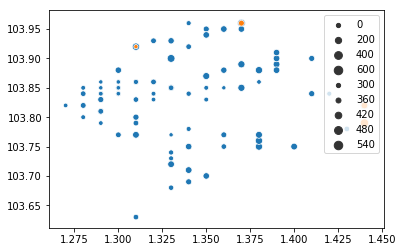

In [106]:
subset1 = subset.copy()
subset1['total_count'] = subset1[['order_count']].groupby(subset1['vendor_geohash']).transform('sum')
subset1 = subset1[['vendor_geohash', 'total_count']][:]
subset1 = subset1.drop_duplicates()
print("Total vendors [blue]: {}".format(len(subset1)))
geo_data = subset1['vendor_geohash'].tolist()
count = subset1['total_count'].tolist()
geo_distribution(geo_data, count)

subset1 = subset.copy()
subset1 = subset1[subset1['vendor_id'].isin(['1057', '1269', '390', '1295'])][:]
subset1['total_count'] = subset1[['order_count']].groupby(subset1['vendor_geohash']).transform('sum')
subset1 = subset1[['vendor_geohash', 'total_count']][:]
subset1 = subset1.drop_duplicates()
print("Top-k vendors [orange]: {}".format(len(subset1)))
geo_data = subset1['vendor_geohash'].tolist()
count = subset1['total_count'].tolist()
geo_distribution(geo_data, count)
del subset1

### Recommending "Chicken Sub" to vendors serving similar items in the south and center of the city
* Not enough market coverage in the south and the center of the city
* Vendors in this region recommended to incorporate this product

### Future Scopes
* #### Hyper-parameter tuning
    * We have hard-coded a specific hyper-parameter at various stages, for example finding the optimal number of cluster, optimal value of number of projections in the SVD etc. We can tune the parameters based on different evaluation metric, for instance analysis of inter-cluster versus intra-cluster variance to find a balanced value of `n_clusters`
* #### Taking Item description into account
    * We can perform Latent Semantic Analysis on Item description to establish relationship between vendors
* #### Collaborative filtering
    * We can treat a vendor as a "user" and use collaborative filtering to recommen a "user" a particular item based on the match between items currently sold by the user and similarity with the items that are widely sold.
* #### Market Basket Analysis
    * We can recommend an item based on other top items. Efficient implementations of market-basket analysis can be explored (for instance A-priori algorithm)